In [20]:
# Load Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [21]:
# Dataset from the Stack Overflow Survey 2021 - SoftwareDeveloper
# To predict the salary of the employee using features such as country, education level and years of experience
# Considering only full time employees

data = pd.read_csv("survey_results_public.csv")
data_salary = data[['Employment','Country','EdLevel','ConvertedCompYearly','YearsCodePro']]
data_salary = data_salary[data_salary['Employment']=='Employed full-time']

In [22]:
# Droppping out the employee details where no salary is mentioned in the survey list

data_salary = data_salary[data_salary['ConvertedCompYearly'].isnull()== False]
data_salary.rename(columns = {'ConvertedCompYearly':'Salary'}, inplace = True)
data_salary = data_salary.drop(columns = 'Employment')

In [23]:
# Dropping out the rows with null values 

data_salary = data_salary.dropna()
data_salary = data_salary.reset_index(drop = True)
data_salary.head(5)

,Country,EdLevel,Salary,YearsCodePro
0,Sweden,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",51552.0,4
1,Spain,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",46482.0,5
2,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",77290.0,6
3,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",17748.0,2
4,Canada,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",46135.0,6


In [24]:
data_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40211 entries, 0 to 40210
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       40211 non-null  object 
 1   EdLevel       40211 non-null  object 
 2   Salary        40211 non-null  float64
 3   YearsCodePro  40211 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [25]:
# To shorten the countries. The value counts of the country less than 400 is marked as other.

def shorten_categories(categories, cutoff):
    
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    
    return categorical_map


country_map = shorten_categories(data_salary.Country.value_counts(), 400)
data_salary['Country'] = data_salary['Country'].map(country_map)
data_salary = data_salary[data_salary['Country']!='Other']
data_salary = data_salary[data_salary['Salary']<=250000]
data_salary = data_salary[data_salary['Salary']>=10000]

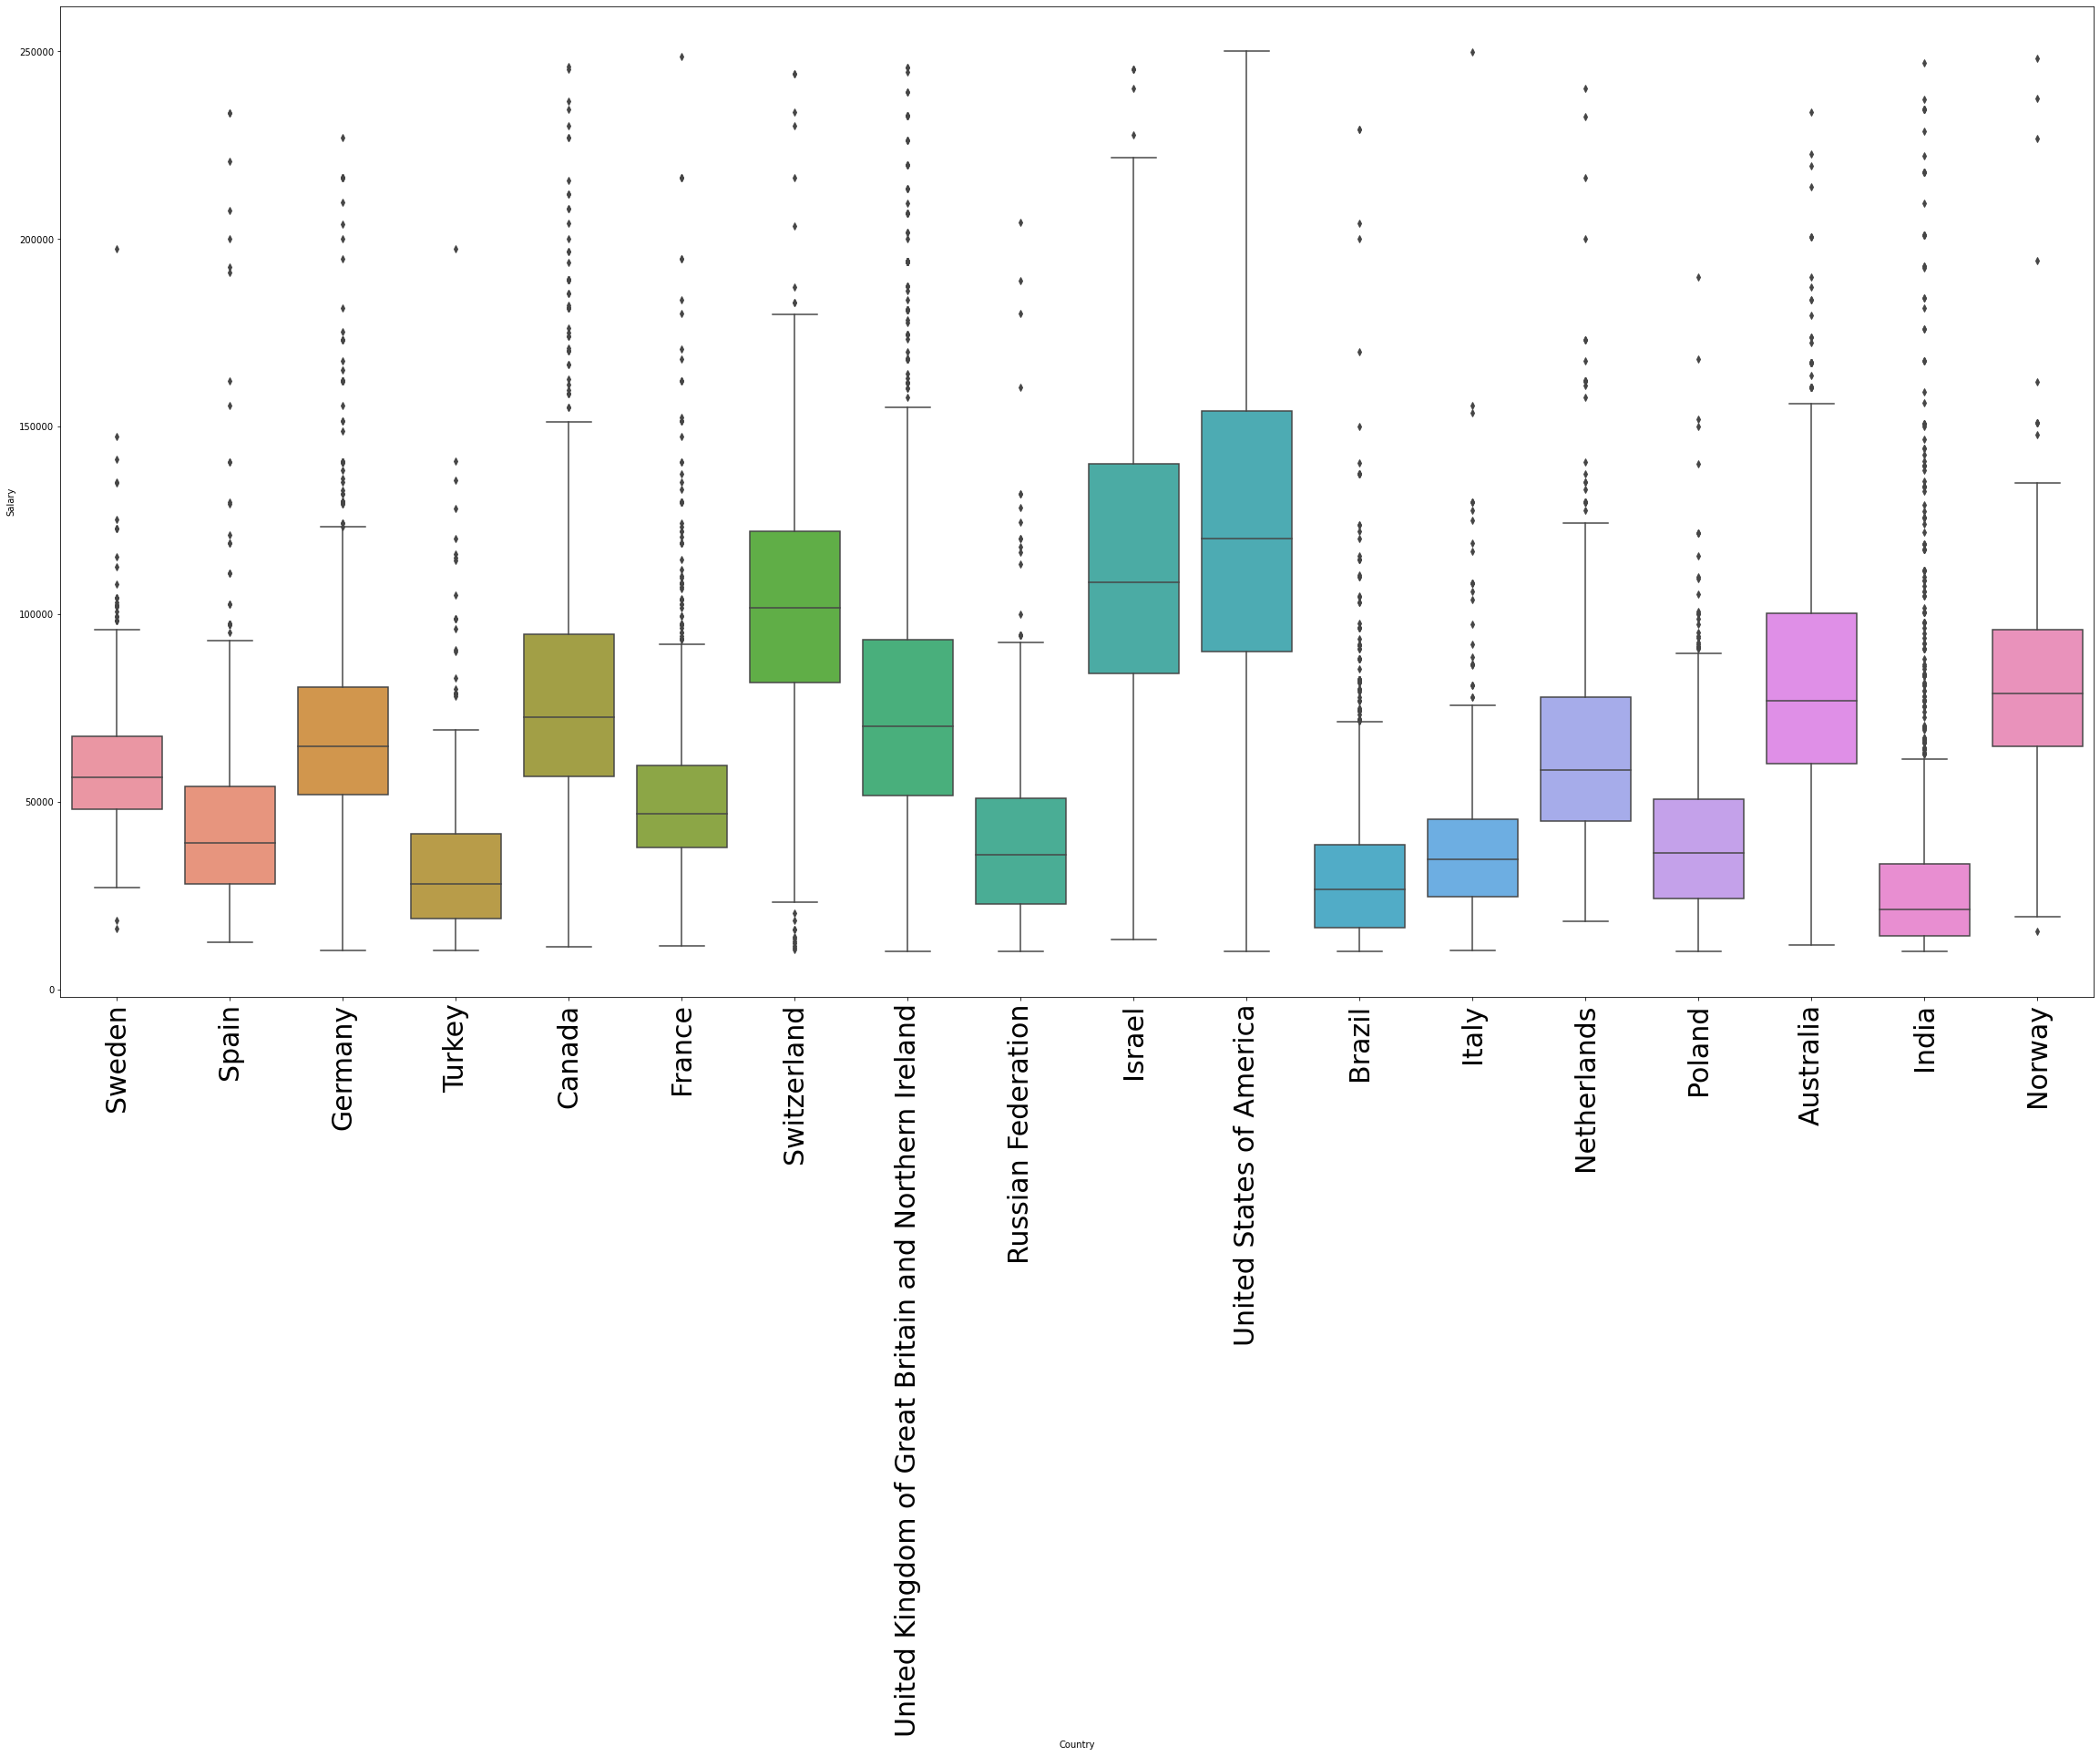

In [26]:
# Boxplot - country feature - to check for the outliers

def check_outlier_boxplot(feature, response):
    f = plt.figure()
    f.set_figwidth(40)
    f.set_figheight(20)
    ax = sns.boxplot(x=feature, y=response, data=data_salary)
    ax = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,fontsize=30)

check_outlier_boxplot('Country', 'Salary')

In [27]:
def clean_years_of_experience(year):
    
    if year == 'Less than 1 year':
        return 0.5
    elif year == 'More than 50 years':
        return 50
    else:
        return year

    
def shorten_degree(degree_name):
    
    if degree_name == 'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)':
        return 'Masters'
    elif degree_name == 'Bachelor’s degree (B.A., B.S., B.Eng., etc.)':
        return 'Bachelor'
    elif degree_name == 'Professional degree (JD, MD, etc.)':
        return 'Post Graduate'
    elif degree_name == 'Other doctoral degree (Ph.D., Ed.D., etc.)':
         return 'Post Graduate'
    else:
        return 'Less than Degree'
  
    
data_salary['YearsCodePro'] = data_salary['YearsCodePro'].apply(clean_years_of_experience)
data_salary['EdLevel'] = data_salary['EdLevel'].apply(shorten_degree)

In [28]:
data_salary['EdLevel'].value_counts()

Bachelor            12635
Masters              6923
Less than Degree     5164
Post Graduate        1508
Name: EdLevel, dtype: int64

In [29]:
# LABEL ENCODING

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

def map_education(edu):
    if edu == 'Less than Degree':
        return 0
    elif edu == 'Bachelor':
        return 1
    elif edu == 'Masters':
        return 2
    elif edu == 'Post Graduate':
        return 3

data_salary['EdLevel']= data_salary['EdLevel'].apply(map_education)

data_salary['YearsCodePro'] = data_salary['YearsCodePro'].astype(float)

le_country = LabelEncoder()
data_salary['Country'] =le_country.fit_transform( data_salary['Country'])

In [30]:
data_salary.head()

,Country,EdLevel,Salary,YearsCodePro
0,13,2,51552.0,4.0
1,12,1,46482.0,5.0
2,4,2,77290.0,6.0
3,15,1,17748.0,2.0
4,2,1,46135.0,6.0


<AxesSubplot:xlabel='YearsCodePro', ylabel='Count'>

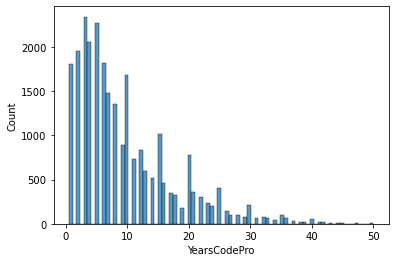

In [31]:
sns.histplot(data=data_salary, x="YearsCodePro")

In [32]:
#country_type = pd.pivot_table(data_salary, values = 'Salary', index = 'Country', aggfunc= np.mean)

from sklearn.metrics import mean_squared_error

def benchmark_feature_mean_error(target, data, feature):
    
    if feature != '':
        data[feature+'mean'] = 0
        for i in data[feature].unique():
            data[feature+'mean'][data[feature]==i] = data[target][data[feature]==i].mean()

        benchmark_feature_mean_error = np.sqrt(mean_squared_error(data[feature+'mean'], data[target]))
        data.drop(columns = feature+'mean', inplace = True)
        return benchmark_feature_mean_error
    
    elif feature == '':
        data['mean']=data[target].mean()
        benchmark_mean_error = np.sqrt(mean_squared_error(data['mean'], data[target]))
        data.drop(columns = 'mean', inplace = True)
        return benchmark_mean_error

In [37]:
Columns = list(data_salary.columns)
Columns.remove('Salary')


for col in Columns:
    benchmark_error = benchmark_feature_mean_error('Salary', data_salary, col)
    print(col,benchmark_error)

Benchmark_mean = benchmark_feature_mean_error('Salary', data_salary, '')
print('All columns',Benchmark_mean)

Country 36336.21467982072
EdLevel 50483.32161800757
YearsCodePro 47013.23605024771
All columns 50591.79035982084


In [38]:
# Spliting the predictors and response varaible

X = data_salary.drop(columns = 'Salary')
Y = data_salary['Salary']

In [39]:
# Evaluating the error from the model
from sklearn.metrics import mean_squared_error , mean_absolute_error
from sklearn.metrics import r2_score

def mean_squared_error_cost(true, predicted):
    cost = np.sqrt(mean_squared_error(true, predicted))
    return cost
    
def r2_score_evaluate(true, predicted):
    cost_r2 = r2_score(true, predicted)
    return cost_r2

In [40]:
# LINEAR REGRESSION MODEL IMPLEMENTATION
# Fit the model Linear regression
from sklearn.linear_model import LinearRegression

regr = LinearRegression()
regr.fit(X,Y)
y_pred = regr.predict(X)
mean_squared_error_cost(Y, y_pred)
r2_score_evaluate(Y, y_pred)

0.3187147268239324

In [41]:
from statsmodels.formula.api import ols
from scipy import stats
import statsmodels.api as sm

est = sm.OLS(Y, X)
est = est.fit()
est.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Salary   R-squared (uncentered):                   0.799
Model:                            OLS   Adj. R-squared (uncentered):              0.799
Method:                 Least Squares   F-statistic:                          3.481e+04
Date:                Fri, 26 Aug 2022   Prob (F-statistic):                        0.00
Time:                        17:40:44   Log-Likelihood:                     -3.1672e+05
No. Observations:               26230   AIC:                                  6.335e+05
Df Residuals:                   26227   BIC:                                  6.335e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Country       4389.3697     33.737    130.107      0.000    4323.244    4455.495
EdLevel       8542.4857    266.261     32.083      0.000    8020.599    9064.373
YearsCodePro  2283.9840     30.674     74.460      0.000    2223.861    2344.107
==============================================================================
Omnibus:                     2364.188   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3454.268
Skew:                           0.712   Prob(JB):                         0.00
Kurtosis:                       4.065   Cond. No.                         16.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
y_est_predict = est.predict(X)
mean_squared_error_cost(Y, y_est_predict)
r2_score_evaluate(Y, y_est_predict)

0.2962301285694341

In [43]:
# CHECKING FOR THE ASSUMPTIONS

def check_homoscedastic(Y, y_pred):
    residuals = pd.DataFrame({
        'fitted_values': Y,
        'predicted_values': y_pred })

    residuals['residuals'] = residuals['fitted_values']-residuals['predicted_values']
    plt.figure(figsize=(20,5), facecolor='w', edgecolor = 'b')
    f = range(0,26230) # 26230 rows - data points
    k = [0 for i in range(0, 26230)]
    plt.scatter(f, residuals.residuals[:], label = 'residuals')
    plt.plot(f, k , color = 'red', label = 'regression line')
    plt.xlabel('fitted points')
    plt.ylabel('residuals')
    plt.title('Residual plot')

# CHECKING FOR THE ASSUMPTIONS - residuals are normally distributed or not

def check_residuals(Y, y_pred):
    residuals = pd.DataFrame({
        'fitted_values': Y,
        'predicted_values': y_pred })
    residuals['residuals'] = residuals['fitted_values']-residuals['predicted_values']
    
    plt.figure(figsize=(20,5), facecolor='w', edgecolor = 'b')
    plt.hist(residuals.residuals, bins = 150)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of error terms')

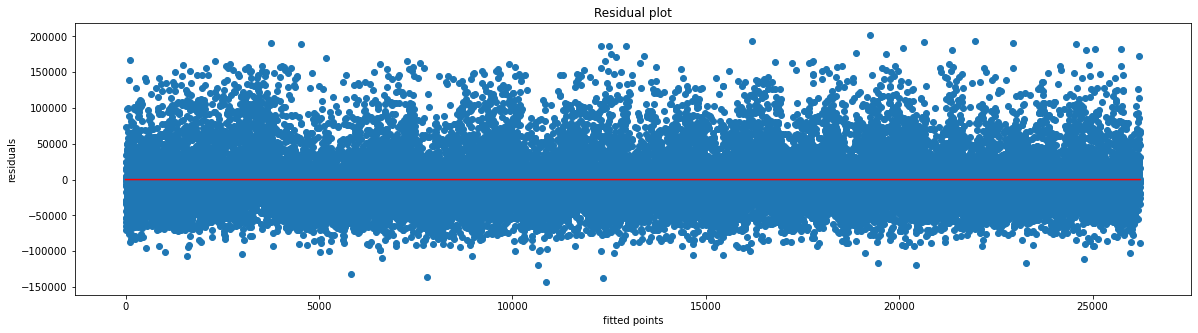

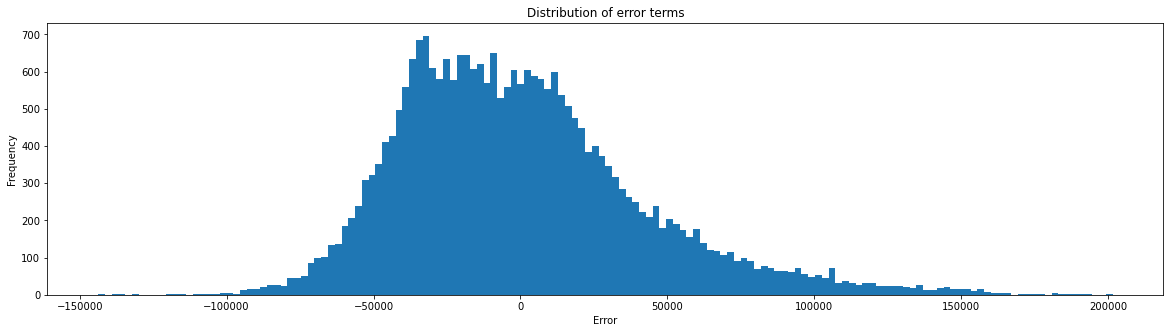

In [44]:
check_homoscedastic(Y, y_pred) # condition is satisfied
check_residuals(Y, y_pred) # condition is satisfied

In [45]:
# DECISION TREE REGRESSOR MODEL IMPLEMENTATION

from sklearn.tree import DecisionTreeRegressor


dec_tree_reg = DecisionTreeRegressor(random_state=0, max_depth = 25)  # depth 25 is optimal
dec_tree_reg = dec_tree_reg.fit(X, Y)
y_dec_pred = dec_tree_reg.predict(X)
print(mean_squared_error_cost(Y, y_dec_pred))
print(r2_score_evaluate(Y, y_dec_pred))

31267.17519371074
0.6180406049659067


In [46]:
# RANDOM FOREST REGRESSOR MODEL IMPLEMENTATION

from sklearn.ensemble import RandomForestRegressor

random_forest_reg = RandomForestRegressor(random_state=0, max_depth = 25)
random_forest_reg.fit(X, Y)
y_random_pred = random_forest_reg.predict(X)
print(mean_squared_error_cost(Y, y_random_pred))
r2_score_evaluate(Y, y_random_pred)

31335.604055755302


0.6163669233926896

In [47]:
model = dec_tree_reg

In [48]:
input = np.array([['United States of America', 'Masters', 15]])
input[:,0] = le_country.transform(input[:,0])
input[:,1] = map_education(input[:,1])
input = input.astype(float)

In [49]:
import pickle

data = {"model": model, 'country': le_country, 'education': map_education }
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(data, file)

In [50]:
with open('saved_steps.pkl', 'rb') as file:
    data = pickle.load(file)
    
regressor_loaded = data['model']
country =data['country']
map_education = data['education']


In [51]:
le_country

LabelEncoder()

In [52]:
y = regressor_loaded.predict(input)
y

array([148942.20512821])